# PROGENy: resource of pathway responsive genes

## Introduction

PROGENy is a comprehensive resource containing a curated collection of pathways and its target genes. PROGENy can be understood as a model that can be used to estimate pathway activities from the levels of expression of target genes.

Here is how to get access to PROGENy's model:

In [1]:
# Load all required packages for this notebook
import pandas as pd
import numpy as np
import progeny
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import igraph as ig

In [2]:
model = progeny.load_model(
    organism='Human' # If working with mouse, set to Mouse
)

model

pathway,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
gene,,,,,,,,,,,,,,
A1BG,0.000000,-0.083706,0.000000,0.181923,0.273006,-1.074258,-0.159083,-0.769794,1.355691,-0.159952,0.988912,-0.984502,0.000000,0.364424
A1BG-AS1,0.000000,0.220597,0.000000,-0.309718,0.111877,0.199728,0.691975,0.592087,0.474941,0.939625,-0.836907,0.527528,0.000000,0.426449
A1CF,0.048810,0.231615,-0.083563,-0.294282,-0.317370,-0.071811,0.202949,-0.011099,-0.217977,0.150338,-0.144021,0.006831,0.199347,0.068142
A2M,-0.133702,-0.025458,0.005991,0.601669,0.217537,-0.602958,0.121887,-4.132639,-0.201018,0.253494,0.511739,1.041986,0.412543,1.037447
A2M-AS1,0.000000,-1.290472,0.000000,-0.078330,-1.111661,-1.141365,-0.599125,-4.002327,-0.624086,-0.190952,0.326502,-1.267320,0.000000,-0.323611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.000000,0.415251,0.000000,-0.032611,-0.752743,0.350720,-0.124060,0.055051,-0.759533,-0.271693,0.503127,-0.134556,0.000000,-0.532939
ZYG11B,0.000000,-2.053099,0.000000,-0.201762,-0.847000,-1.710863,-2.553345,-0.586663,-0.079109,-1.681167,-0.262016,-0.841210,0.000000,0.783740
ZYX,-1.377319,2.513890,-1.632761,0.864610,-0.328818,1.450113,0.145275,3.322799,1.110002,0.964071,0.638241,1.449194,0.058564,-0.415364


Each pathway (columns) targets a set of genes (rows). Non zero values represent an interaction between a target gene and a pathway. Depending on the type of interaction, there will be positive and negative interactions. A positive edge means that if a given pathway is active, its target will have high levels of gene expression. On the contrary, a negative edge means that if a given pathway is active, its target will not show gene expression.

Here is a visual representation of different pathways (red nodes) and a subset of target genes (green nodes). Green edges are positive interactions and red edges are negative:

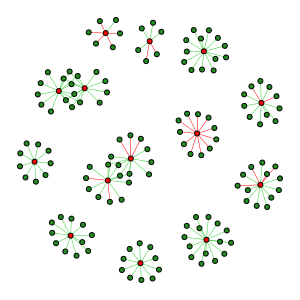

In [3]:
# To explore more visualizations change these parameters
num_pws = 14
num_genes = 140
#

sub_prog = progeny.load_model(top=25).values[:num_genes,:num_pws]
sub_prog = sub_prog[np.any(sub_prog != 0, axis=1)]
sub_prog = sub_prog[:, np.any(sub_prog != 0, axis=0)]
num_genes, num_pws = sub_prog.shape
adj_m = np.vstack([np.zeros((sub_prog.shape[1], sub_prog.shape[1])), sub_prog])
adj_m = np.hstack([adj_m, np.zeros((adj_m.shape[0],adj_m.shape[0]-adj_m.shape[1]))])
g = ig.Graph.Adjacency((np.abs(adj_m) > 0).tolist())
g.vs['color'] = (['red'] * num_pws) + (['forestgreen'] * num_genes)
weights = adj_m[np.where(adj_m)]
g.es['color'] = ['limegreen' if w > 0 else 'red' for w in weights]
ig.plot(g, layout='fr', vertex_size=5, edge_arrow_size=0, edge_width=0.5, bbox=(300,300))

Overall, there is a balanced number between positive and negative edges, but it depends on each pathway. Here is a heatmap of the model weights. Some pathways have more edges than others, for instance, p53 compared to WNT.

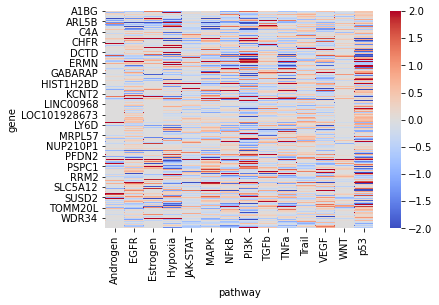

In [4]:
sns.heatmap(model, cmap='coolwarm', robust=True, vmin=-2, vmax=2)
plt.show()

## Confidence levels

In PROGENy, each pathway-target interaction has an associated pvalue. Therefore, PROGENy can be filtered to use the top significant $N$ target genes per pathway.

Let's compare different $N$:

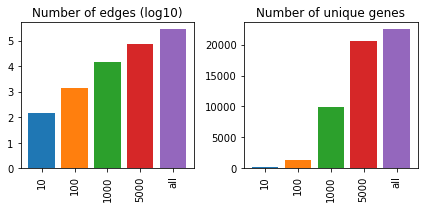

In [5]:
levels = [10, 100, 1000, 5000, None]

fig, axes = plt.subplots(1,2, figsize=(6,3), tight_layout=True, facecolor='white')
axes = axes.flatten()

for n_genes in levels:
    model = progeny.load_model(
        top=n_genes # Number of top significant target genes per pathway to use
    )
    n_genes = str(n_genes)
    if n_genes == 'None':
        n_genes = 'all'
    num_edges = np.sum(model.values != 0)
    num_genes, num_pws = model.shape
    label = n_genes
    
    axes[0].set_title('Number of edges (log10)')
    axes[0].bar(label, np.log10(num_edges))
    axes[0].tick_params(axis='x', rotation=90)
    
    axes[1].set_title('Number of unique genes')
    axes[1].bar(label, num_genes)
    axes[1].tick_params(axis='x', rotation=90)

When working with bulk data-sets we recommend to use the top 100 genes. However, due to the  nature of single cell, gene dropouts can affect the results if $N$ is too small. Because of this, we recommend to use around 1000 target genes in single cell.

## Footprint-based enrichment analysis

Classic enrichment analysis focuses on the levels of expression of the elements of a given biological process to estimate its activity. In contrast, footprint-based enrichment analysis instead estimates activities using molecular readouts considered to be downstream. Thus, expression of targets can be inferred as a more robust proxy of the pathway activity (Dugourd and Saez-Rodriguez 2019).

Following this idea, we use PROGENy weighted model to estimate pathway activities using footprint-based enrichment analysis from gene expression profiles. PROGENy can be coupled with any footprint-based statistic to compute pathway activities. In this implementation we use the normalized mean of expression of the target genes as statistic but we could have used any other.

## Toy example

Here is a toy example for just for visualizing porpuses, for proper usage of the package see other notebooks.

We will generate expression for 10 genes for one sample and we will compute the activites of 3 pathways.

In [6]:
genes_lst = ['TNFAIP2', 'IL6', 'CXCL5', 'DUSP6', 'NKX3-1', 'IDH1', 'PLAUR', 'IL15', 'IRF2', 'TNFSF10']
expr = np.array([445, 410, 396, 100, 349, 40, 55, 400, 300, 500])
pws_lst = ['EGFR', 'NFkB', 'JAK-STAT']

Let's load PROGENy and trim the model to fit our expression matrix

In [7]:
model = progeny.load_model(top=1000).loc[genes_lst,pws_lst]
model

pathway,EGFR,NFkB,JAK-STAT
gene,,,
TNFAIP2,0.000000,10.910807,0.000000
IL6,0.000000,21.770635,0.000000
CXCL5,0.000000,7.179648,0.000000
DUSP6,12.629313,0.000000,0.000000
NKX3-1,0.000000,2.372983,0.000000
IDH1,0.000000,-2.443497,0.000000
PLAUR,3.470994,5.127519,0.000000
IL15,0.000000,5.146568,4.242639
IRF2,-1.952087,2.790701,2.903168


Then we compute the pathway activities and plot them in a bipartite graph

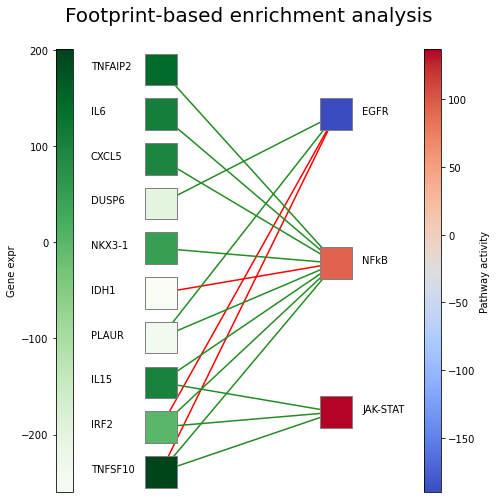

In [8]:
# Create coords for plots
g_coords = np.array([np.repeat(0, len(genes_lst)), np.arange(0, -len(genes_lst), -1)]).T
t_coords = np.array([np.repeat(1, len(pws_lst)), np.arange(-1, -len(genes_lst), -len(genes_lst)/len(pws_lst))]).T

# Center expression
expr = expr - np.mean(expr)

# Calculate pathway activities
pw_act = expr.T.dot(model.values) / np.sum(np.abs(model.values), axis=0)

# Order edges
pos_edg = []
neg_edg = []
for i,gene in enumerate(model.values):
    for j,pw in enumerate(gene):
        edg = [g_coords[i][1], t_coords[j][1]]
        if pw > 0:
            pos_edg.append(edg)
        elif pw < 0:
            neg_edg.append(edg)
            
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot graph
fig, ax = plt.subplots(1,1, figsize=(7,7), facecolor='white', tight_layout=True)
ax.set_title('Footprint-based enrichment analysis', fontsize=20, y=1.05)
ax.plot(np.array(neg_edg).T, color='red', zorder=1)
ax.plot(np.array(pos_edg).T, color='forestgreen', zorder=1)
gene_plot = ax.scatter(g_coords[:,0], g_coords[:,1], marker='s', s=1000, c=expr, cmap='Greens', zorder=2, edgecolor='gray')
pw_plot = ax.scatter(t_coords[:,0], t_coords[:,1], marker='s', s=1000, c=pw_act, cmap='coolwarm', zorder=2, edgecolor='gray')
ax.set_xlim(-0.5, 1.5)

# Add gene/pw labels
for i,g in enumerate(genes_lst):
    ax.text(g_coords[i][0]-0.4, g_coords[i][1], g)
for i,t in enumerate(pws_lst):
    ax.text(t_coords[i][0]+0.15, t_coords[i][1], t)

# Format color bars
divider = make_axes_locatable(ax)
cax = divider.append_axes('left', size='5%', pad=0)
fig.colorbar(gene_plot,cax,orientation='vertical', label='Gene expr')
cax.yaxis.set_label_position('left')
cax.yaxis.set_ticks_position('left')
cax = divider.append_axes('right', size='5%', pad=0)
fig.colorbar(pw_plot,cax,orientation='vertical', label='Pathway activity')
ax.axis('off')
plt.show()

On the left in green there are the levels of expression of our 10 genes. On the right in blue/red there are the pathway activities. Each pathway is connected by edges to a set of target genes according to PROGENy's model. Green edges are positive interactions and red are negative.

Just by looking at the gene expression we can see that there are some genes that are coordinated (they share high or low expression profiles). However, if there are more than 10 genes it becomes hard to interpret what is going on by just looking at gene expression. By using footprint-based enrichment analysis with PROGENy, we can summarize these regulation events into pathway activities. They can be understood as a prior knowledge based dimensionality reduction.

In this specific toy example, NFkB and JAK-STAT appear to be activated since all of their target genes have high gene expression. On the other hand, EGFR seems to be less active since their negative targets have high expression while their positive targets are lowly expressed.